## Import Libraries and Preprocess Data

In [3]:
import pandas as pd
import os
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("/content/drive/MyDrive/Complaints/processed_complaints.csv")

In [5]:
data = data.drop(['Unnamed: 0'],1)
data.head(5)

<ipython-input-5-17f5b84c75cf>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = data.drop(['Unnamed: 0'],1)


,Product,Complaint
0,Debt Collection,owe money never received bill indicating balan...
1,Debt Collection,attempting collect fund valuation service prov...
2,Credit Reporting and Services,experian didnt consent inquiry also name incor...
3,Banking Services,citibank froze account contained time make col...
4,Credit Reporting and Services,accordance fair credit reporting act account v...


In [6]:
data['Product'].value_counts()

Credit Reporting and Services    545868
Debt Collection                  191946
Credit/Prepaid Cards             102075
Mortgages                         97748
Banking Services                  97420
Loans                             77347
Crypto Currency                      16
Name: Product, dtype: int64

In [7]:
product_map = []
product_dict = {}
for i,prod in enumerate(data['Product'].unique()):
    product_map.append({"Product":prod, "id":i})
    product_dict[prod] = i

In [8]:
product_dict

{'Debt Collection': 0,
 'Credit Reporting and Services': 1,
 'Banking Services': 2,
 'Mortgages': 3,
 'Credit/Prepaid Cards': 4,
 'Loans': 5,
 'Crypto Currency': 6}

## PART 1: Predicting Subject

In [9]:
data['output'] = data['Product'].map(product_dict)

In [10]:
data.head()

,Product,Complaint,output
0,Debt Collection,owe money never received bill indicating balan...,0
1,Debt Collection,attempting collect fund valuation service prov...,0
2,Credit Reporting and Services,experian didnt consent inquiry also name incor...,1
3,Banking Services,citibank froze account contained time make col...,2
4,Credit Reporting and Services,accordance fair credit reporting act account v...,1


In [11]:
data = data[['Complaint','output']]

In [12]:
data.head()

,Complaint,output
0,owe money never received bill indicating balan...,0
1,attempting collect fund valuation service prov...,0
2,experian didnt consent inquiry also name incor...,1
3,citibank froze account contained time make col...,2
4,accordance fair credit reporting act account v...,1


In [13]:
data['Complaint'] = data['Complaint'].astype(str)

<ipython-input-13-fb2db329b3c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Complaint'] = data['Complaint'].astype(str)


In [13]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
stop_words = stopwords.words('english')
STOPWORDS = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [15]:
MAX_NB_WORDS = 5000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Complaint'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 152117 unique tokens


In [16]:
X = tokenizer.texts_to_sequences(data['Complaint'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1112420, 50)


In [17]:
Y = pd.get_dummies(data['output']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1112420, 7)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(889936, 50) (889936, 7)
(222484, 50) (222484, 7)


In [19]:
X.shape

(1112420, 50)

In [20]:
Y.shape

(1112420, 7)

### Build Model

In [36]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
#model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(CuDNNLSTM(100))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           500000    
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 50, 100)          0         
 lDropout1D)                                                     
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 100)               80800     
                                                                 
 dense_3 (Dense)             (None, 7)                 707       
                                                                 
Total params: 581,507
Trainable params: 581,507
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
Y[1]

array([1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [37]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
12515/12515 [==============================] - 94s 7ms/step - loss: 0.5024 - accuracy: 0.8263 - val_loss: 0.4445 - val_accuracy: 0.8457
Epoch 2/10
12515/12515 [==============================] - 92s 7ms/step - loss: 0.4301 - accuracy: 0.8493 - val_loss: 0.4259 - val_accuracy: 0.8522
Epoch 3/10
12515/12515 [==============================] - 91s 7ms/step - loss: 0.4066 - accuracy: 0.8576 - val_loss: 0.4186 - val_accuracy: 0.8548
Epoch 4/10
12515/12515 [==============================] - 92s 7ms/step - loss: 0.3892 - accuracy: 0.8635 - val_loss: 0.4145 - val_accuracy: 0.8568
Epoch 5/10
12515/12515 [==============================] - 91s 7ms/step - loss: 0.3744 - accuracy: 0.8686 - val_loss: 0.4154 - val_accuracy: 0.8570
Epoch 6/10
12515/12515 [==============================] - 94s 7ms/step - loss: 0.3615 - accuracy: 0.8731 - val_loss: 0.4169 - val_accuracy: 0.8572
Epoch 7/10
12515/12515 [==============================] - 93s 7ms/step - loss: 0.3509 - accuracy: 0.8768 - val_loss: 0

In [ ]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss')])

In [29]:
epochs = 1
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss')])

12515/12515 [==============================] - 94s 8ms/step - loss: 0.4310 - accuracy: 0.8495 - val_loss: 0.4270 - val_accuracy: 0.8522


In [30]:
epochs = 1
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss')])

12515/12515 [==============================] - 94s 8ms/step - loss: 0.4075 - accuracy: 0.8573 - val_loss: 0.4195 - val_accuracy: 0.8531


In [61]:
import pickle

#model.save("/content/drive/MyDrive/Complaints/Model")
#pickle.dump(model, open("/content/drive/MyDrive/Complaints/Model", 'wb'))
model.save_weights('/content/drive/MyDrive/Complaints/Model.h5')

In [38]:
import matplotlib.pyplot as plt 

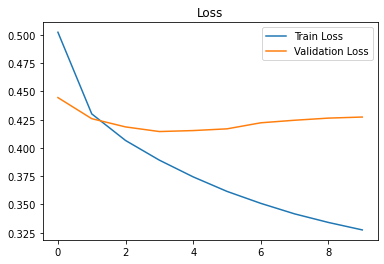

In [55]:
plt.title(label='Loss')
plt.plot(history.history['loss'], label = "Train Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()

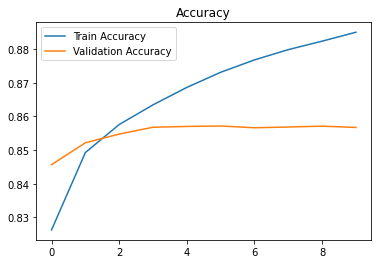

In [57]:
plt.title(label='Accuracy')
plt.plot(history.history['accuracy'], label = "Train Accuracy")
plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
plt.legend()

In [81]:
pred = model.predict(X_test)

6953/6953 [==============================] - 23s 3ms/step


In [87]:

from sklearn.metrics import classification_report

print(classification_report(np.argmax(pred, axis=1), np.argmax(Y_test, axis = 1)))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80     37223
           1       0.93      0.91      0.92    111218
           2       0.85      0.83      0.84     19986
           3       0.88      0.86      0.87     20033
           4       0.74      0.75      0.75     20168
           5       0.68      0.76      0.72     13855
           6       0.14      1.00      0.25         1

    accuracy                           0.86    222484
   macro avg       0.72      0.85      0.73    222484
weighted avg       0.86      0.86      0.86    222484

